<a href="https://colab.research.google.com/github/PamePatzi/Sistema-inteligente-para-monitoreo-e-identificaci-n-temprana-de-melanoma/blob/main/melanoma_a_s_a_p.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SISTEMA INTELIGENTE PARA IDENTIFICACIÓN Y DIAGNOSTICO TEMPRANA DE MELANOMAS (Parte 2)

Para este caso, utilizamos el mismo dataset que se puede encontrar en Kaggle, con téctinas de web scrapping, utilizando la API específica. Este es un segundo modelo realizado en grupo, con la ayuda de un modelo pre-entrenado, MobileNet V2, con el fin de la comparación de resultados con el modelo 1, 

## 1. Importación de las dependencias

In [ ]:
# Se importa dependencias 
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import tensorflow as tf
import pandas as pd
from PIL import Image
from tqdm import tqdm

## 2. Adquicisión de la base de datos

In [ ]:
# Se define las credentiales para acceder a Kaggle
!mkdir ~/.kaggle # Crear el directorio .kaggle
!touch ~/.kaggle/kaggle.json # Crear el archivo kaggle.json
api_token = {"username":"lexipatzi","key":"af4d8478480353a66efb23e233482439"} # Definir las credenciales de API de Kaggle
with open('/root/.kaggle/kaggle.json', 'w') as file: # Guardando las credenciales
    json.dump(api_token, file)
!chmod 600 ~/.kaggle/kaggle.json # Establecer los permisos del archivo kaggle.json

In [ ]:
!kaggle datasets download -d drscarlat/melanoma # Descargar el dataset desde Kaggle
!unzip -qn '/content/melanoma.zip' -d /content/ > /dev/null # Descomprimiendo el dataset 
!rm /content/melanoma.zip # Eliminando el zip
!rm -r dermmel/ # Eliminando el DERMMEL

100% 5.24G/5.26G [00:52<00:00, 175MB/s]
100% 5.26G/5.26G [00:52<00:00, 107MB/s]


In [ ]:
train_dir = '/content/DermMel/train_sep'
validation_dir = '/content/DermMel/test/'
#Designando tamaño de lotes
batch_size = 32
img_size = (224, 244)
NUM_CLASSES = len(os.listdir(train_dir))
#División de dataset de entrenamiento
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,validation_split=0.2,subset="training",seed=123,image_size= img_size,batch_size=batch_size) 
print(train_dataset.class_names)
#Dataset de validación
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,shuffle=True,batch_size=batch_size,image_size=img_size)
print(validation_dataset.class_names)

Found 10682 files belonging to 2 classes.
Using 8546 files for training.
['Melanoma', 'NotMelanoma']
Found 3561 files belonging to 2 classes.
['Melanoma', 'NotMelanoma']


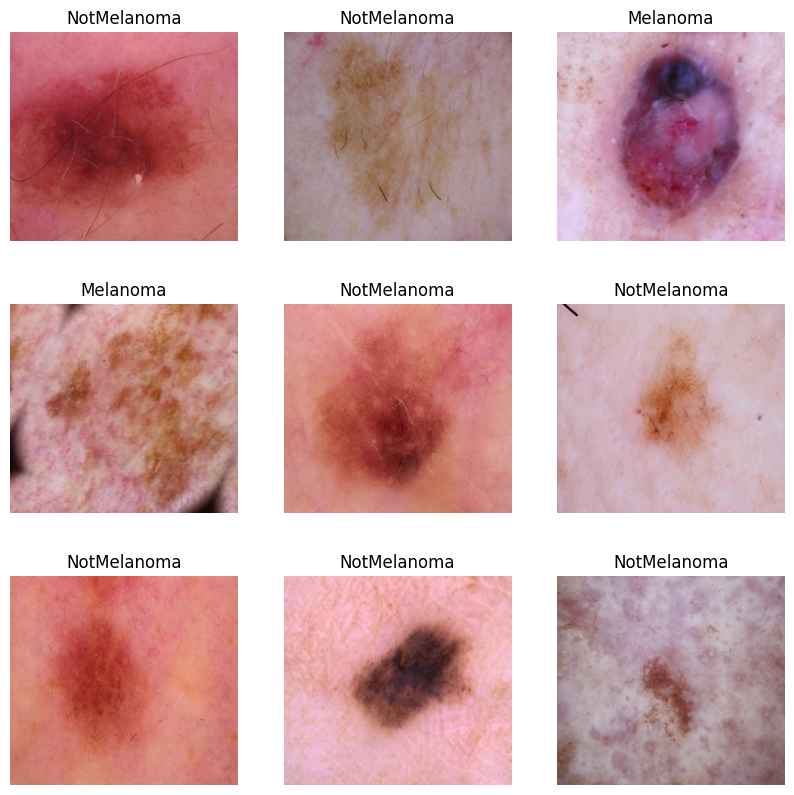

In [ ]:
# Imagenes principales del dataset
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
# Primer lote de imágenes y etiquetas del conjunto de entrenamiento
for images, labels in train_dataset.take(1):
    for i in range(9):     # Primeras 9 imágenes del lote
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
# Extracción conjunto de prueba 
val_batches = tf.data.experimental.cardinality(validation_dataset) #tamaño total de lotes de validación
test_dataset = validation_dataset.take(val_batches // 5) #partiendo dataset en un subconjunto
validation_dataset = validation_dataset.skip(val_batches // 5) #actualizando datos
print('Número de lotes de validación: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Número de lotes de prueba: %d' % tf.data.experimental.cardinality(test_dataset))

Número de lotes de validación: 90
Número de lotes de prueba: 22


## Configuración de la base de datos

### Precarga en búfer

In [ ]:
# Precarga en búfer para cargar imágenes desde el disco sin que la E/S se bloquee
AUTOTUNE = tf.data.AUTOTUNE #determinamos tamaño de buffer
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE) #precarga de datos
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE) 
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE) 

### Aumento de datos

In [ ]:
# Estas capas sólo están activas durante el entrenamiento, cuando se llama a Model.fitz
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

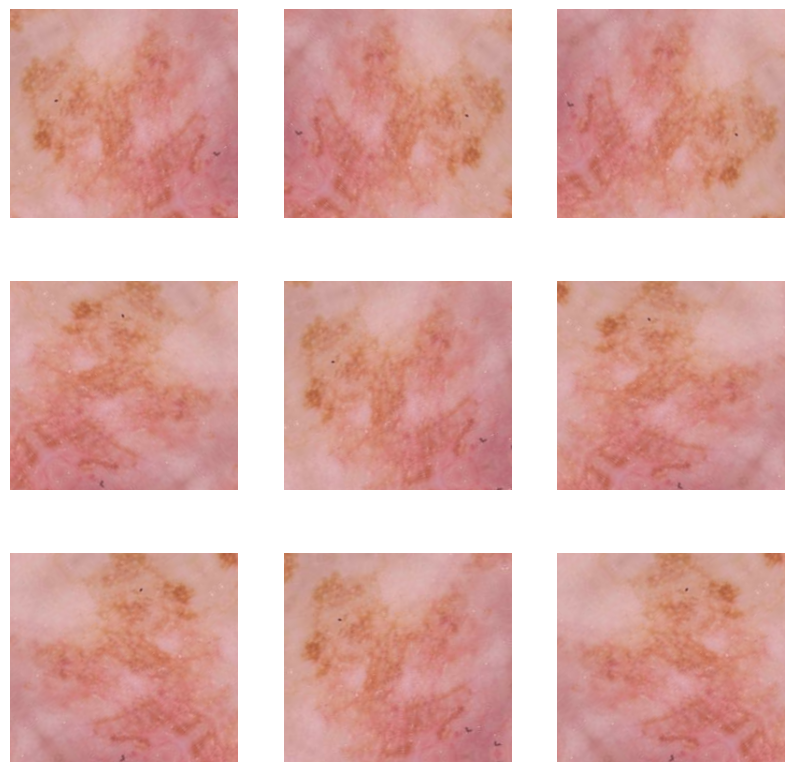

In [ ]:
# Muestra de imagen desde diferentes angulos
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9): #giramos cada imagen 9 veces
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Reescalamiento de los pixeles

In [ ]:
# Este modelo espera valores en pixel entre [-1,1], normaliza valores de pixeles
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

## Creación del modelo

Se creará el modelo a partir del modelo MobileNet V2 desarrollado en Google. Este modelo se encuentrá preentrenado en el conjunto de datos ImageNet, un gran conjunto de datos compuesto por 1,4 millones de imágenes y 1.000 clases. 
En primer lugar, hay que elegir qué capa de MobileNet V2 se va a utilizar para la extracción de características. La última capa de clasificación (la "superior", ya que la mayoría de los diagramas de modelos de aprendizaje automático van de abajo a arriba) no es muy útil. En su lugar, seguirá la práctica común de depender de la última capa antes de la operación de aplanamiento. Esta capa se denomina "capa cuello de botella". Las características de la capa cuello de botella son más generales que las de la capa final/superior.

In [ ]:
IMG_SHAPE = img_size + (3,) # Se define la forma de entrada de la imagen, que es el tamaño de la imagen (ancho, alto) más los canales de color (3 para RGB)
# Se crea el modelo base utilizando la arquitectura pre-entrenada de MobileNet V2
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
# El parámetro "input_shape" especifica la forma de entrada del modelo base, que es la forma de la imagen
# El parámetro "include_top=False" indica que se deben excluir las capas fully-connected (top) del modelo pre-entrenado
# El parámetro "weights='imagenet'" carga los pesos pre-entrenados del modelo en caso de estar disponibles

9406464/9406464 [==============================] - 0s 0us/step


### Extracción de características

In [ ]:
# Extractor de características que convierte cada imagen de 160x160x3 en un bloque de características de 5x5x1280 
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 8, 1280)


### Congelado de la base convulsionada

Se congela la base que impide que los pesos de una capa determinada se actualicen durante el entrenamiento

In [ ]:
base_model.trainable = False # El indicador entrenable de todo el modelo en False congelará todas ellas.

### Capas BatchNormalization

Muchos modelos contienen capas tf.keras.layers.BatchNormalization. Esta capa es un caso especial y deben tomarse precauciones en el contexto del ajuste fino.

In [ ]:
# Arquitectura del modelo base 
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 244, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 122, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 122, 32  128         ['Conv1[0][0]']                  
                                )                                              

### Añadiendo un cabezal de clasificación

Utilizando una capa tf.keras.layers.GlobalAveragePooling2D para convertir las características en un único vector de 1280 elementos por imagen.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # Se define la capa de promedio global
feature_batch_average = global_average_layer(feature_batch) # Se aplica la capa de promedio global a un lote de mapas de características
print(feature_batch_average.shape) # Se imprime la forma resultante al reducir su tamaño espacial a un solo valor por canal

(32, 1280)


Aplicando una capa tf.keras.layers.Dense para convertir estas características en una única predicción por imagen.

In [ ]:
# Se definen las capas densas
hidden_layer1 = tf.keras.layers.Dense(1000, activation='relu')
hidden_layer2 = tf.keras.layers.Dense(1000, activation='relu')
hidden_layer3 = tf.keras.layers.Dense(1000, activation='relu')
prediction_layer = tf.keras.layers.Dense(NUM_CLASSES)
prediction_batch = hidden_layer1(feature_batch_average) # Se aplica la primera capa densa a los valores promediados
prediction_batch = hidden_layer2(prediction_batch) # Se aplica la segunda capa densa
prediction_batch = hidden_layer3(prediction_batch) # Se aplica la tercera capa densa 
prediction_batch = prediction_layer(prediction_batch) # Se aplica la capa de predicción final
print(prediction_batch.shape) # La forma resultante de las predicciones

(32, 2)


Se construye un modelo encadenando data augmentation, rescaling, base_model, reescalado, base_model y el extractor de caracteristicas utilizando la API funcional de Keras.
Como se mencionó anteriormente, utilice training=False ya que nuestro modelo contiene una capa BatchNormalization.

In [ ]:
inputs = tf.keras.Input(shape=(img_size[0], img_size[1], 3)) # Se define la entrada del modelo
x = data_augmentation(inputs) # Se aplica la data augmentation 
x = rescale(x) # Se realiza un reescalado de las imágenes
x = base_model(x, training=False) # Se pasa el tensor de entrada a través del modelo base pre-entrenado (MobileNet V2)
x = global_average_layer(x) # Se aplica una capa de promedio global para obtener valores promediados de las características
x = tf.keras.layers.Dropout(0.2)(x) # Se aplica una capa de dropout para evitar el sobreajuste
x = hidden_layer1(x) # Se aplica la primera capa densa a los valores promediados
x = hidden_layer2(x) # Se aplica la segunda capa densa 
x = hidden_layer3(x) # Se aplica la tercera capa densa
x = tf.keras.layers.Dropout(0.2)(x) # Se aplica una capa de dropout adicional
outputs = prediction_layer(x) # Se aplica la capa de predicción final a la salida
model = tf.keras.Model(inputs, outputs) # Se crea el modelo utilizando las capas de entrada y salida definidas

### Compilación del modelo

Se compila el modelo antes de entrenarlo, con una funcion de perdida Binary Crossentrop por que el modelo proporcionara una salida lineal. 

In [ ]:
base_learning_rate = 1E-6 # Se define la tasa de aprendizaje base
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 244, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 244, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 244, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0     

### Entrenamiento del modelo

Después de entrenar durante 10 epocas, se debería ver un aproximado de un 94% de precisión en el conjunto de validación.

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

90/90 [==============================] - 20s 144ms/step - loss: 0.7546 - accuracy: 0.4998


In [ ]:
print("Perdida inicial: {:.2f}".format(loss0))
print("Accuracy inicial: {:.2f}".format(accuracy0))

Perdida inicial: 0.75
Accuracy inicial: 0.50


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
268/268 [==============================] - 57s 190ms/step - loss: 0.6173 - accuracy: 0.6823 - val_loss: 0.5042 - val_accuracy: 0.8708
Epoch 2/10
268/268 [==============================] - 45s 167ms/step - loss: 0.4754 - accuracy: 0.8342 - val_loss: 0.3921 - val_accuracy: 0.9020
Epoch 3/10
268/268 [==============================] - 43s 157ms/step - loss: 0.3906 - accuracy: 0.8777 - val_loss: 0.3221 - val_accuracy: 0.9079
Epoch 4/10
268/268 [==============================] - 46s 167ms/step - loss: 0.3354 - accuracy: 0.8918 - val_loss: 0.2819 - val_accuracy: 0.9121
Epoch 5/10
268/268 [==============================] - 43s 159ms/step - loss: 0.3030 - accuracy: 0.8984 - val_loss: 0.2543 - val_accuracy: 0.9174
Epoch 6/10
268/268 [==============================] - 43s 158ms/step - loss: 0.2766 - accuracy: 0.9051 - val_loss: 0.2415 - val_accuracy: 0.9191
Epoch 7/10
268/268 [==============================] - 43s 159ms/step - loss: 0.2669 - accuracy: 0.9056 - val_loss: 0.2314 - val_ac

In [ ]:

loss0, accuracy0 = model.evaluate(validation_dataset)

90/90 [==============================] - 13s 116ms/step - loss: 0.2197 - accuracy: 0.9230


### Curvas de aprendizaje

Accuracy y loss del entrenamiento y validación cuando se utiliza el modelo base MobileNetV2 como extractor de características fijo.

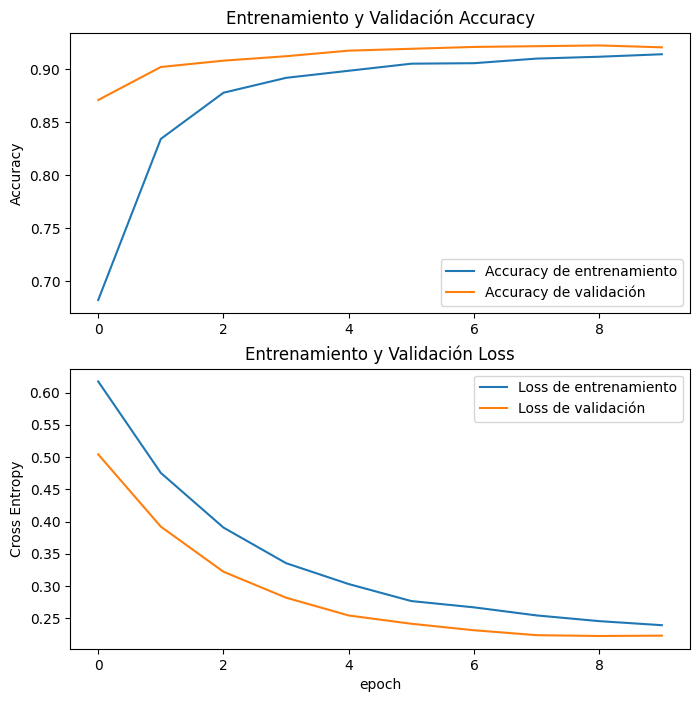

In [ ]:
# Extraer las métricas de entrenamiento del historial del modelo
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear una nueva figura para los gráficos
plt.figure(figsize=(8, 8))

# Precisión de entrenamiento y validación
plt.subplot(2, 1, 1)
plt.plot(acc, label='Accuracy de entrenamiento') 
plt.plot(val_acc, label='Accuracy de validación') 
plt.legend(loc='lower right')  
plt.ylabel('Accuracy')
plt.title('Entrenamiento y Validación Accuracy')

# Pérdida de entrenamiento y validación
plt.subplot(2, 1, 2)  
plt.plot(loss, label='Loss de entrenamiento') 
plt.plot(val_loss, label='Loss de validación')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Entrenamiento y Validación Loss')
plt.xlabel('epoch')

plt.show()

tf.keras.layers.BatchNormalization y tf.keras.layers.Dropout afectan a la precisión durante el entrenamiento. Se desactivan al calcular la pérdida de validación. En menor medida, también las métricas de entrenamiento informan de la media de una época, mientras que las métricas de validación evalúan después de la época.

## Ajuste o afinamiento
Una forma de aumentar aún más el rendimiento es entrenar (o "afinar") los pesos de las capas superiores del modelo preentrenado junto con el entrenamiento del clasificador que has añadido. El proceso de entrenamiento forzará el ajuste de los pesos desde mapas de características genéricas a características asociadas específicamente con el conjunto de datos.

### Descongelando las capas superiores del modelo


In [ ]:
#Descongelando el modelo
base_model.trainable = True
# Capas en el modelo base
print("Numero de capas: ", len(base_model.layers))

Numero de capas:  154


In [ ]:
# Ajuste fino desde la capa 20
fine_tune_at = 20

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 244, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 244, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 244, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0     

In [ ]:
len(model.trainable_variables)

143

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [ ]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/15
268/268 [==============================] - 77s 192ms/step - loss: 0.2312 - accuracy: 0.9156 - val_loss: 0.2182 - val_accuracy: 0.9216
Epoch 11/15
268/268 [==============================] - 51s 189ms/step - loss: 0.2237 - accuracy: 0.9210 - val_loss: 0.2157 - val_accuracy: 0.9237
Epoch 12/15
268/268 [==============================] - 51s 186ms/step - loss: 0.2189 - accuracy: 0.9201 - val_loss: 0.2144 - val_accuracy: 0.9240
Epoch 13/15
268/268 [==============================] - 51s 187ms/step - loss: 0.2188 - accuracy: 0.9203 - val_loss: 0.2172 - val_accuracy: 0.9233
Epoch 14/15
268/268 [==============================] - 51s 186ms/step - loss: 0.2130 - accuracy: 0.9201 - val_loss: 0.2141 - val_accuracy: 0.9237
Epoch 15/15
268/268 [==============================] - 52s 190ms/step - loss: 0.2109 - accuracy: 0.9215 - val_loss: 0.2113 - val_accuracy: 0.9247


In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model')

In [ ]:
!zip -r saved_model.zip saved_model

  adding: saved_model/ (stored 0%)
  adding: saved_model/my_model/ (stored 0%)
  adding: saved_model/my_model/variables/ (stored 0%)
  adding: saved_model/my_model/variables/variables.index (deflated 76%)
  adding: saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: saved_model/my_model/assets/ (stored 0%)
  adding: saved_model/my_model/keras_metadata.pb (deflated 96%)
  adding: saved_model/my_model/fingerprint.pb (stored 0%)
  adding: saved_model/my_model/saved_model.pb (deflated 91%)


Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

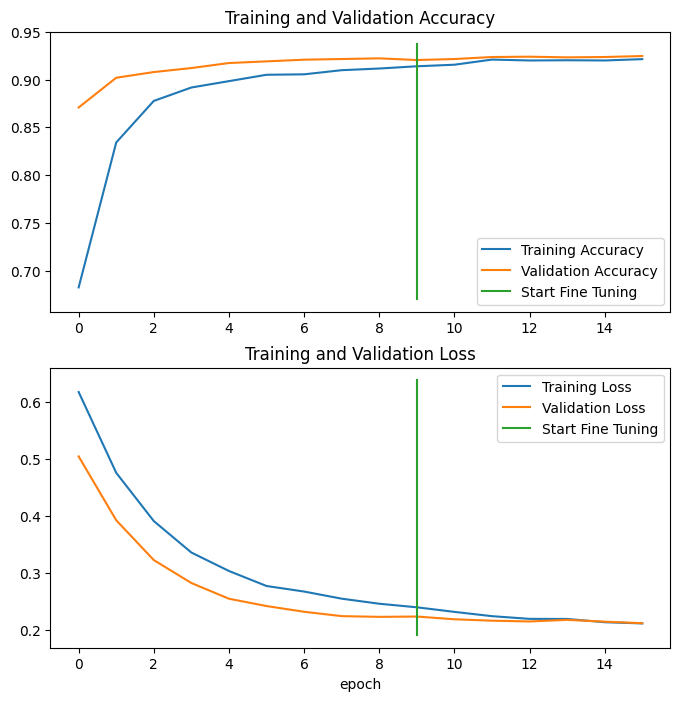

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

22/22 [==============================] - 3s 109ms/step - loss: 0.2174 - accuracy: 0.9276
Test accuracy : 0.9275568127632141


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [0 0 1 1 1 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 0 1 1 0 1]
Labels:
 [0 0 1 1 1 1 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 1 1 1 0 0 0 1 1 0 1]


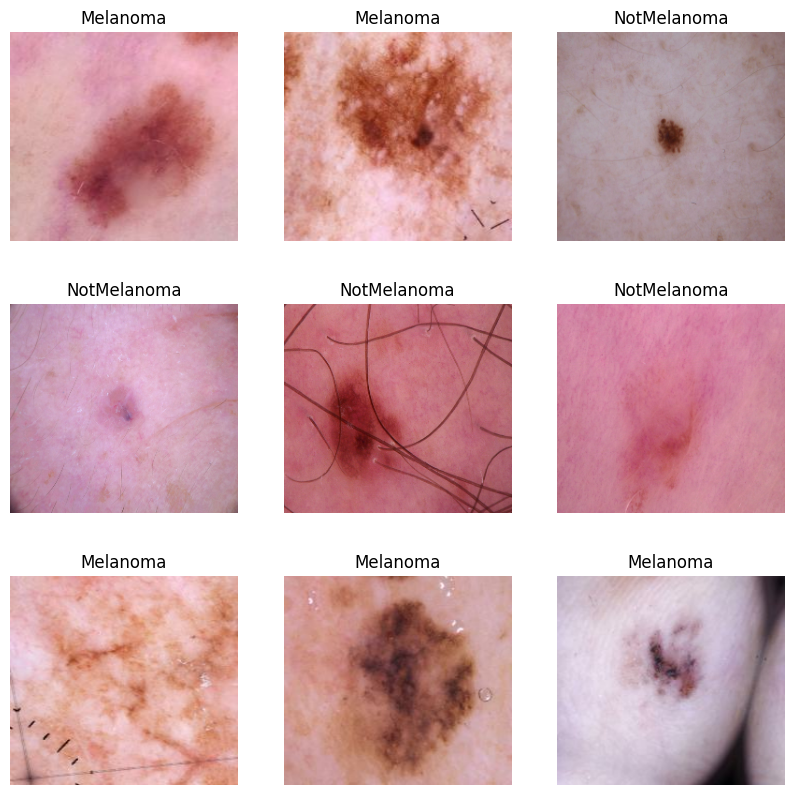

In [ ]:

image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply a sigmoid since our model returns logits
predictions = tf.nn.softmax(predictions, axis=1)
predictions = tf.argmax(predictions,axis=1)


print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

In [ ]:
model_path = '/content/drive/MyDrive/modelo.h5'
model.save(model_path)

In [ ]:
model.save('/content/model2.h5')

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import numpy as np

# Carga del modelo entrenado
model = keras.models.load_model('/content/model2.h5')
#imagen de prueba
img_path = '/content/AUG_0_86.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
imga = image.img_to_array(img)
imga = np.expand_dims(imga, axis=0)
imga /= 255.0
#predicción
prediction = model.predict(imga)
print(prediction)
#class_idx = int(prediction[0][0])
#print("predicción",class_idx)
if prediction == 0:
    print("La imagen es un Melanoma.")
else:
    print("La imagen es un NoMelanoa.")

ValueError: ignored